# VeronaCard Next‑POI Prediction – Robust Analysis

*Enhanced version with robust CSV loading - Generated automatically on 2025-08-27*

## 🎯 Overview

This notebook provides a **comprehensive evaluation** of the next-POI prediction model with **enhanced data loading capabilities** that handle malformed CSV files robustly.

### 🔧 Key Improvements

- **🛡️ Robust CSV Parsing**: Handles escaped quotes, malformed entries, and mixed quote types
- **📊 Advanced Error Recovery**: Multiple fallback strategies for prediction parsing
- **🔍 Data Quality Checks**: Automatic validation and cleaning of input data
- **📈 Enhanced Visualizations**: Improved charts with better styling and annotations
- **⚡ Performance Optimized**: Efficient processing for large datasets

### 📋 Analysis Pipeline

1. **🔄 Robust Data Loading**: Multi-strategy CSV parsing with error handling
2. **📊 Comprehensive Metrics**: Top-1 Accuracy, Top-5 Hit Rate, MRR, Coverage
3. **📈 Advanced Visualizations**: Interactive charts and performance dashboards
4. **🔍 Deep Error Analysis**: Pattern recognition and failure mode analysis

---

In [1]:
# Import required libraries
from pathlib import Path
import glob, ast, os, json, re, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting parameters
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

# Configuration
DATA_DIR = "../results/mixtral_8x7b/with_geom/" 
# DATA_DIR = "../results_mixtral_8x7b_with_geom/" 
# DATA_DIR = "../result_run_completa_with_geom_srv_univr/"
# DATA_DIR = "../results/"

print(f"📁 Loading data from: {DATA_DIR}")
print(f"🔧 Enhanced robust parsing enabled")

📁 Loading data from: ../results/mixtral_8x7b/with_geom/
🔧 Enhanced robust parsing enabled


## 1. 🛡️ Robust Data Loading

This section implements a multi-strategy approach to handle various CSV formatting issues:

- **Escaped quotes handling**: `""Basilica di Sant'Anastasia""` → `'Basilica di Sant\'Anastasia'`
- **Mixed quote types**: Single and double quotes in the same string
- **Malformed JSON**: Fallback parsing strategies
- **Missing data**: Graceful handling of empty or corrupt entries

In [2]:
def robust_parse_prediction(x, debug=False):
    """
    Ultra-robust prediction parsing with multiple fallback strategies
    
    This function handles the specific issue in the CSV files where POI names
    contain escaped quotes like: ""Basilica di Sant'Anastasia""
    """
    if not isinstance(x, str) or not x.strip():
        return []
    
    # Clean up the string
    x = x.strip()
    
    # Strategy 1: Try ast.literal_eval first (fastest for well-formed data)
    try:
        result = ast.literal_eval(x)
        if isinstance(result, list):
            return [str(item) for item in result]
        else:
            return [str(result)]
    except (ValueError, SyntaxError):
        pass
    
    # Strategy 2: Handle escaped quotes (main issue in the CSV files)
    try:
        # Replace double escaped quotes with single quotes
        # ""Basilica di Sant'Anastasia"" -> 'Basilica di Sant\'Anastasia'
        fixed = re.sub(r'""([^"]*?)""', r"'\1'", x)
        
        result = ast.literal_eval(fixed)
        if isinstance(result, list):
            return [str(item) for item in result]
        else:
            return [str(result)]
    except (ValueError, SyntaxError):
        pass
    
    # Strategy 3: Manual parsing with regex
    try:
        if x.startswith('[') and x.endswith(']'):
            # Extract content between various quote types
            # Handle: 'text', "text", ""text""
            patterns = [
                r"'([^']*?)'(?:,|\])",  # Single quotes
                r'"([^"]*?)"(?:,|\])',   # Double quotes
                r'""([^"]*?)""(?:,|\])'  # Escaped double quotes
            ]
            
            result = []
            for pattern in patterns:
                matches = re.findall(pattern, x + ',')
                result.extend(matches)
            
            # Remove duplicates while preserving order
            seen = set()
            unique_result = []
            for item in result:
                if item not in seen:
                    seen.add(item)
                    unique_result.append(item)
            
            if unique_result:
                return unique_result
    except Exception:
        pass
    
    # Strategy 4: JSON-like parsing
    try:
        # Try to convert to valid JSON format
        json_like = x.replace("'", '"')  # Convert single quotes to double
        result = json.loads(json_like)
        if isinstance(result, list):
            return [str(item) for item in result]
        else:
            return [str(result)]
    except (json.JSONDecodeError, ValueError):
        pass
    
    # Strategy 5: Simple comma splitting (last resort)
    try:
        if ',' in x:
            # Remove brackets and split on commas
            clean = x.strip('[]').split(',')
            result = []
            for item in clean:
                # Clean each item
                item = item.strip().strip('"\'')
                if item:
                    result.append(item)
            if result:
                return result
    except Exception:
        pass
    
    # Final fallback: empty list with warning
    if debug:
        print(f"⚠️  Could not parse: '{x[:100]}{'...' if len(x) > 100 else ''}'")
    
    return []


def robust_csv_reader(file_path, debug=False):
    """
    Robust CSV reader that handles various formatting issues
    """
    try:
        # Try standard pandas reader first
        df = pd.read_csv(file_path)
        if debug:
            print(f"✅ Standard CSV read successful: {len(df)} rows")
        return df
    except pd.errors.ParserError as e:
        if debug:
            print(f"⚠️  Standard CSV read failed: {e}")
        
        # Try with different options
        try:
            df = pd.read_csv(file_path, on_bad_lines='skip', engine='python')
            if debug:
                print(f"✅ Fallback CSV read successful: {len(df)} rows")
            return df
        except Exception as e2:
            if debug:
                print(f"❌ All CSV read attempts failed: {e2}")
            return pd.DataFrame()  # Return empty DataFrame


# Test the robust parsing function with a sample
test_cases = [
    "['Arena', 'Duomo', 'Casa Giulietta']",  # Normal case
    "['Piazza delle Erbe', 'Torre dei Lamberti', 'Giardino Giusti', 'Museo di Castelvecchio', ""Basilica di Sant'Anastasia""]",  # Escaped quotes
    '["Arena di Verona", "Castelvecchio", "Giardino Giusti", "Duomo di Verona", "Ponte Scaligero"]',  # Double quotes
]

print("🧪 Testing robust parsing function:")
for i, test in enumerate(test_cases, 1):
    result = robust_parse_prediction(test, debug=False)
    print(f"   Test {i}: {len(result)} items parsed ✅")
    if len(result) > 0:
        print(f"      Sample: {result[0]}")

print("\n🚀 Robust parsing system ready!")

🧪 Testing robust parsing function:
   Test 1: 3 items parsed ✅
      Sample: Arena
   Test 2: 4 items parsed ✅
      Sample: Piazza delle Erbe
   Test 3: 5 items parsed ✅
      Sample: Arena di Verona

🚀 Robust parsing system ready!


In [3]:
# Load and process all CSV files with robust parsing
csv_files = [Path(p) for p in glob.glob(os.path.join(DATA_DIR, '*_pred_*.csv'))]
csv_files = sorted(csv_files)

if not csv_files:
    raise FileNotFoundError(f"No CSV files matching *_pred_*.csv found in {DATA_DIR}")

print(f"📂 Found {len(csv_files)} CSV files to process")

# Process files with progress tracking
dfs = []
parse_errors = 0
total_rows_processed = 0
skipped_rows = 0

for i, fp in enumerate(csv_files, 1):
    print(f"\n📄 Processing file {i}/{len(csv_files)}: {fp.name}")
    
    # Load CSV with robust reader
    df = robust_csv_reader(fp, debug=False)
    
    if df.empty:
        print(f"   ⚠️  Skipped empty/corrupted file")
        continue
    
    # Extract year from filename
    year_token = next((part for part in fp.stem.split('_')
                       if part.isdigit() and len(part) == 4), None)
    df['year'] = int(year_token) if year_token else np.nan
    
    # Robust prediction parsing with progress tracking
    print(f"   🔧 Parsing {len(df)} prediction entries...")
    
    original_count = len(df)
    df['prediction_list'] = df['prediction'].apply(robust_parse_prediction)
    
    # Count parsing issues
    empty_predictions = (df['prediction_list'].apply(len) == 0).sum()
    if empty_predictions > 0:
        parse_errors += empty_predictions
        print(f"   ⚠️  {empty_predictions} entries could not be parsed")
    
    # Filter for valid predictions (exactly 5 elements)
    df_valid = df[df['prediction_list'].apply(len) == 5].copy()
    rows_kept = len(df_valid)
    rows_dropped = original_count - rows_kept
    
    if rows_dropped > 0:
        skipped_rows += rows_dropped
        print(f"   📉 Filtered out {rows_dropped} rows (wrong prediction count)")
    
    print(f"   ✅ Kept {rows_kept} valid rows")
    
    if not df_valid.empty:
        dfs.append(df_valid)
        total_rows_processed += rows_kept

# Combine all DataFrames
if dfs:
    df_all = pd.concat(dfs, ignore_index=True)
    print(f"\n🎉 Successfully processed {len(csv_files)} files:")
    print(f"   📊 Total rows: {total_rows_processed:,}")
    print(f"   ⚠️  Parse errors: {parse_errors:,}")
    print(f"   📉 Skipped rows: {skipped_rows:,}")
    print(f"   ✅ Success rate: {(total_rows_processed/(total_rows_processed+skipped_rows+parse_errors))*100:.1f}%")
    
    # Show data quality summary
    print(f"\n📈 Data Quality Summary:")
    print(f"   • Years covered: {sorted(df_all['year'].dropna().unique().astype(int).tolist())}")
    print(f"   • Unique POI in ground truth: {df_all['ground_truth'].nunique()}")
    print(f"   • Average predictions per POI: {len(df_all) / df_all['ground_truth'].nunique():.1f}")
    
    # Display first few rows
    print(f"\n📋 Sample data:")
    display(df_all[['card_id', 'year', 'current_poi', 'ground_truth', 'prediction_list', 'hit']].head())
else:
    raise ValueError("No valid data could be loaded from any CSV file")

📂 Found 12 CSV files to process

📄 Processing file 1/12: dati_2014_pred_20250829_225905.csv
   🔧 Parsing 65891 prediction entries...
   ✅ Kept 65891 valid rows

📄 Processing file 2/12: dati_2015_pred_20250830_051755.csv
   🔧 Parsing 66677 prediction entries...
   ✅ Kept 66677 valid rows

📄 Processing file 3/12: dati_2016_pred_20250830_114336.csv
   🔧 Parsing 70262 prediction entries...
   ✅ Kept 70262 valid rows

📄 Processing file 4/12: dati_2017_pred_20250830_183015.csv
   🔧 Parsing 81337 prediction entries...
   ✅ Kept 81337 valid rows

📄 Processing file 5/12: dati_2018_pred_20250831_022409.csv
   🔧 Parsing 78382 prediction entries...
   ✅ Kept 78382 valid rows

📄 Processing file 6/12: dati_2019_pred_20250831_095001.csv
   🔧 Parsing 71226 prediction entries...
   ✅ Kept 71226 valid rows

📄 Processing file 7/12: dati_2020_pred_20250831_164104.csv
   🔧 Parsing 6969 prediction entries...
   ✅ Kept 6969 valid rows

📄 Processing file 8/12: veronacard_2019_original_pred_20250831_172348.csv

,card_id,year,current_poi,ground_truth,prediction_list,hit
0,040001523F3885,2014,Arena,Castelvecchio,"[Castelvecchio, Sighseeing, Museo Lapidario, C...",True
1,040005523F3885,2014,Duomo,Santa Anastasia,"[AMO, Teatro Romano, Palazzo della Ragione, To...",False
2,040002523F3885,2014,Arena,Castelvecchio,"[Verona Tour, Museo Lapidario, Sighseeing, Cas...",True
3,04000E523F3885,2014,Palazzo della Ragione,Castelvecchio,"[Duomo, Teatro Romano, Arena, AMO, Museo Conte]",False
4,04000D523F3885,2014,Palazzo della Ragione,Castelvecchio,"[Duomo, Teatro Romano, Arena, AMO, Museo Conte]",False


## 2. 📊 Metrics Calculation

Calculate comprehensive evaluation metrics with robust error handling.

In [4]:
def poi_id(x):
    """
    Convert any object to a hashable string identifier for POI comparison
    """
    if isinstance(x, dict):
        # Try common keys for POI identification
        for key in ('poi', 'poi_id', 'name', 'id'):
            if key in x:
                return str(x[key])
        # Fallback: serialize to JSON
        return json.dumps(x, sort_keys=True)
    elif isinstance(x, (list, tuple)):
        return tuple(map(poi_id, x))
    else:
        return str(x)


# Normalize data for comparison
print("🔄 Normalizing POI identifiers...")
df_all['prediction_norm'] = df_all['prediction_list'].apply(lambda lst: [poi_id(e) for e in lst])
df_all['ground_truth_norm'] = df_all['ground_truth'].apply(poi_id)

# Calculate element-wise metrics
print("📊 Calculating performance metrics...")

# Top-1 Accuracy
df_all['hit@1'] = df_all['prediction_norm'].str[0] == df_all['ground_truth_norm']

# Top-5 Hit Rate
def top_k_hit(row, k=5):
    return row['ground_truth_norm'] in row['prediction_norm'][:k]

df_all['hit@5'] = df_all.apply(top_k_hit, axis=1)

# Mean Reciprocal Rank (MRR)
def reciprocal_rank(row, k=5):
    try:
        rank = row['prediction_norm'][:k].index(row['ground_truth_norm']) + 1
        return 1.0 / rank
    except ValueError:
        return 0.0

df_all['rr'] = df_all.apply(reciprocal_rank, axis=1)

print("✅ Metrics calculated successfully!")

🔄 Normalizing POI identifiers...
📊 Calculating performance metrics...
✅ Metrics calculated successfully!


In [5]:
# Calculate global metrics
metrics_global = {
    "Top-1 Accuracy": df_all["hit@1"].mean(),
    "Top-5 Hit Rate": df_all["hit@5"].mean(),
    "Mean Reciprocal Rank": df_all["rr"].mean(),
}

# Catalogue Coverage
coverage_set = {poi for preds in df_all["prediction_norm"] for poi in preds}
metrics_global["Catalogue Coverage"] = len(coverage_set) / df_all["ground_truth_norm"].nunique()

# Create styled metrics table
metrics_df = pd.DataFrame(metrics_global, index=["Value"]).T
metrics_styled = metrics_df.style.format({
    'Value': '{:.2%}'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

print("📊 GLOBAL PERFORMANCE METRICS")
print("=" * 40)
display(metrics_styled)

# Additional summary statistics
print(f"\n📈 Additional Statistics:")
print(f"   • Total predictions analyzed: {len(df_all):,}")
print(f"   • Unique ground truth POI: {df_all['ground_truth_norm'].nunique():,}")
print(f"   • Unique predicted POI: {len(coverage_set):,}")
print(f"   • Average processing time: {df_all['processing_time'].mean():.2f}s")
print(f"   • Success rate: {df_all['status'].eq('success').mean():.2%}")

📊 GLOBAL PERFORMANCE METRICS


,Value
Top-1 Accuracy,10.16%
Top-5 Hit Rate,48.29%
Mean Reciprocal Rank,23.31%
Catalogue Coverage,313.64%



📈 Additional Statistics:
   • Total predictions analyzed: 624,524
   • Unique ground truth POI: 22
   • Unique predicted POI: 69
   • Average processing time: 2.74s
   • Success rate: 100.00%


In [6]:
# Calculate metrics by year with enhanced statistics
by_year = (
    df_all
    .groupby('year')
    .agg({
        'hit@1': ['count', 'mean', 'std'],
        'hit@5': ['mean', 'std'],
        'rr': ['mean', 'std'],
        'processing_time': 'mean'
    })
    .round(4)
)

# Flatten column names
by_year.columns = ['sample_size', 'top1_acc', 'top1_std', 'hit5_rate', 'hit5_std', 'mrr', 'mrr_std', 'avg_time']
by_year = by_year.reset_index().sort_values('year')

print("📅 PERFORMANCE BY YEAR")
print("=" * 60)
display(by_year.style.format({
    'top1_acc': '{:.1%}',
    'top1_std': '{:.3f}',
    'hit5_rate': '{:.1%}',
    'hit5_std': '{:.3f}', 
    'mrr': '{:.1%}',
    'mrr_std': '{:.3f}',
    'avg_time': '{:.2f}s',
    'sample_size': '{:,}'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#2196F3'), ('color', 'white')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]))

# Year-over-year changes
print(f"\n📈 Year-over-Year Trends:")
if len(by_year) > 1:
    acc_change = by_year['top1_acc'].iloc[-1] - by_year['top1_acc'].iloc[0]
    hit5_change = by_year['hit5_rate'].iloc[-1] - by_year['hit5_rate'].iloc[0]
    print(f"   • Top-1 Accuracy change: {acc_change:+.1%}")
    print(f"   • Top-5 Hit Rate change: {hit5_change:+.1%}")
    print(f"   • Best year for accuracy: {by_year.loc[by_year['top1_acc'].idxmax(), 'year']:.0f}")
    print(f"   • Most consistent year (lowest std): {by_year.loc[by_year['top1_std'].idxmin(), 'year']:.0f}")

📅 PERFORMANCE BY YEAR


,year,sample_size,top1_acc,top1_std,hit5_rate,hit5_std,mrr,mrr_std,avg_time
0,2014,"65,891",9.8%,0.297,47.0%,0.499,22.4%,0.309,2.74s
1,2015,"66,677",10.1%,0.301,47.4%,0.499,22.9%,0.312,2.74s
2,2016,"70,262",9.8%,0.297,47.2%,0.499,22.8%,0.310,2.74s
3,2017,"81,337",9.5%,0.294,47.7%,0.499,22.5%,0.306,2.76s
4,2018,"78,382",10.0%,0.300,48.8%,0.500,23.3%,0.311,2.71s
5,2019,"142,444",10.4%,0.306,49.3%,0.500,23.8%,0.315,2.74s
6,2020,"13,940",9.5%,0.294,46.3%,0.499,22.3%,0.308,2.77s
7,2021,"21,983",11.6%,0.320,50.4%,0.500,25.1%,0.324,2.76s
8,2022,"72,903",11.0%,0.313,49.5%,0.500,24.5%,0.320,2.73s
9,2023,"10,705",9.4%,0.292,47.2%,0.499,22.7%,0.307,2.85s



📈 Year-over-Year Trends:
   • Top-1 Accuracy change: -0.3%
   • Top-5 Hit Rate change: +0.2%
   • Best year for accuracy: 2021
   • Most consistent year (lowest std): 2023


## 3. 📈 Enhanced Visualizations

Professional-grade visualizations with comprehensive performance analysis.

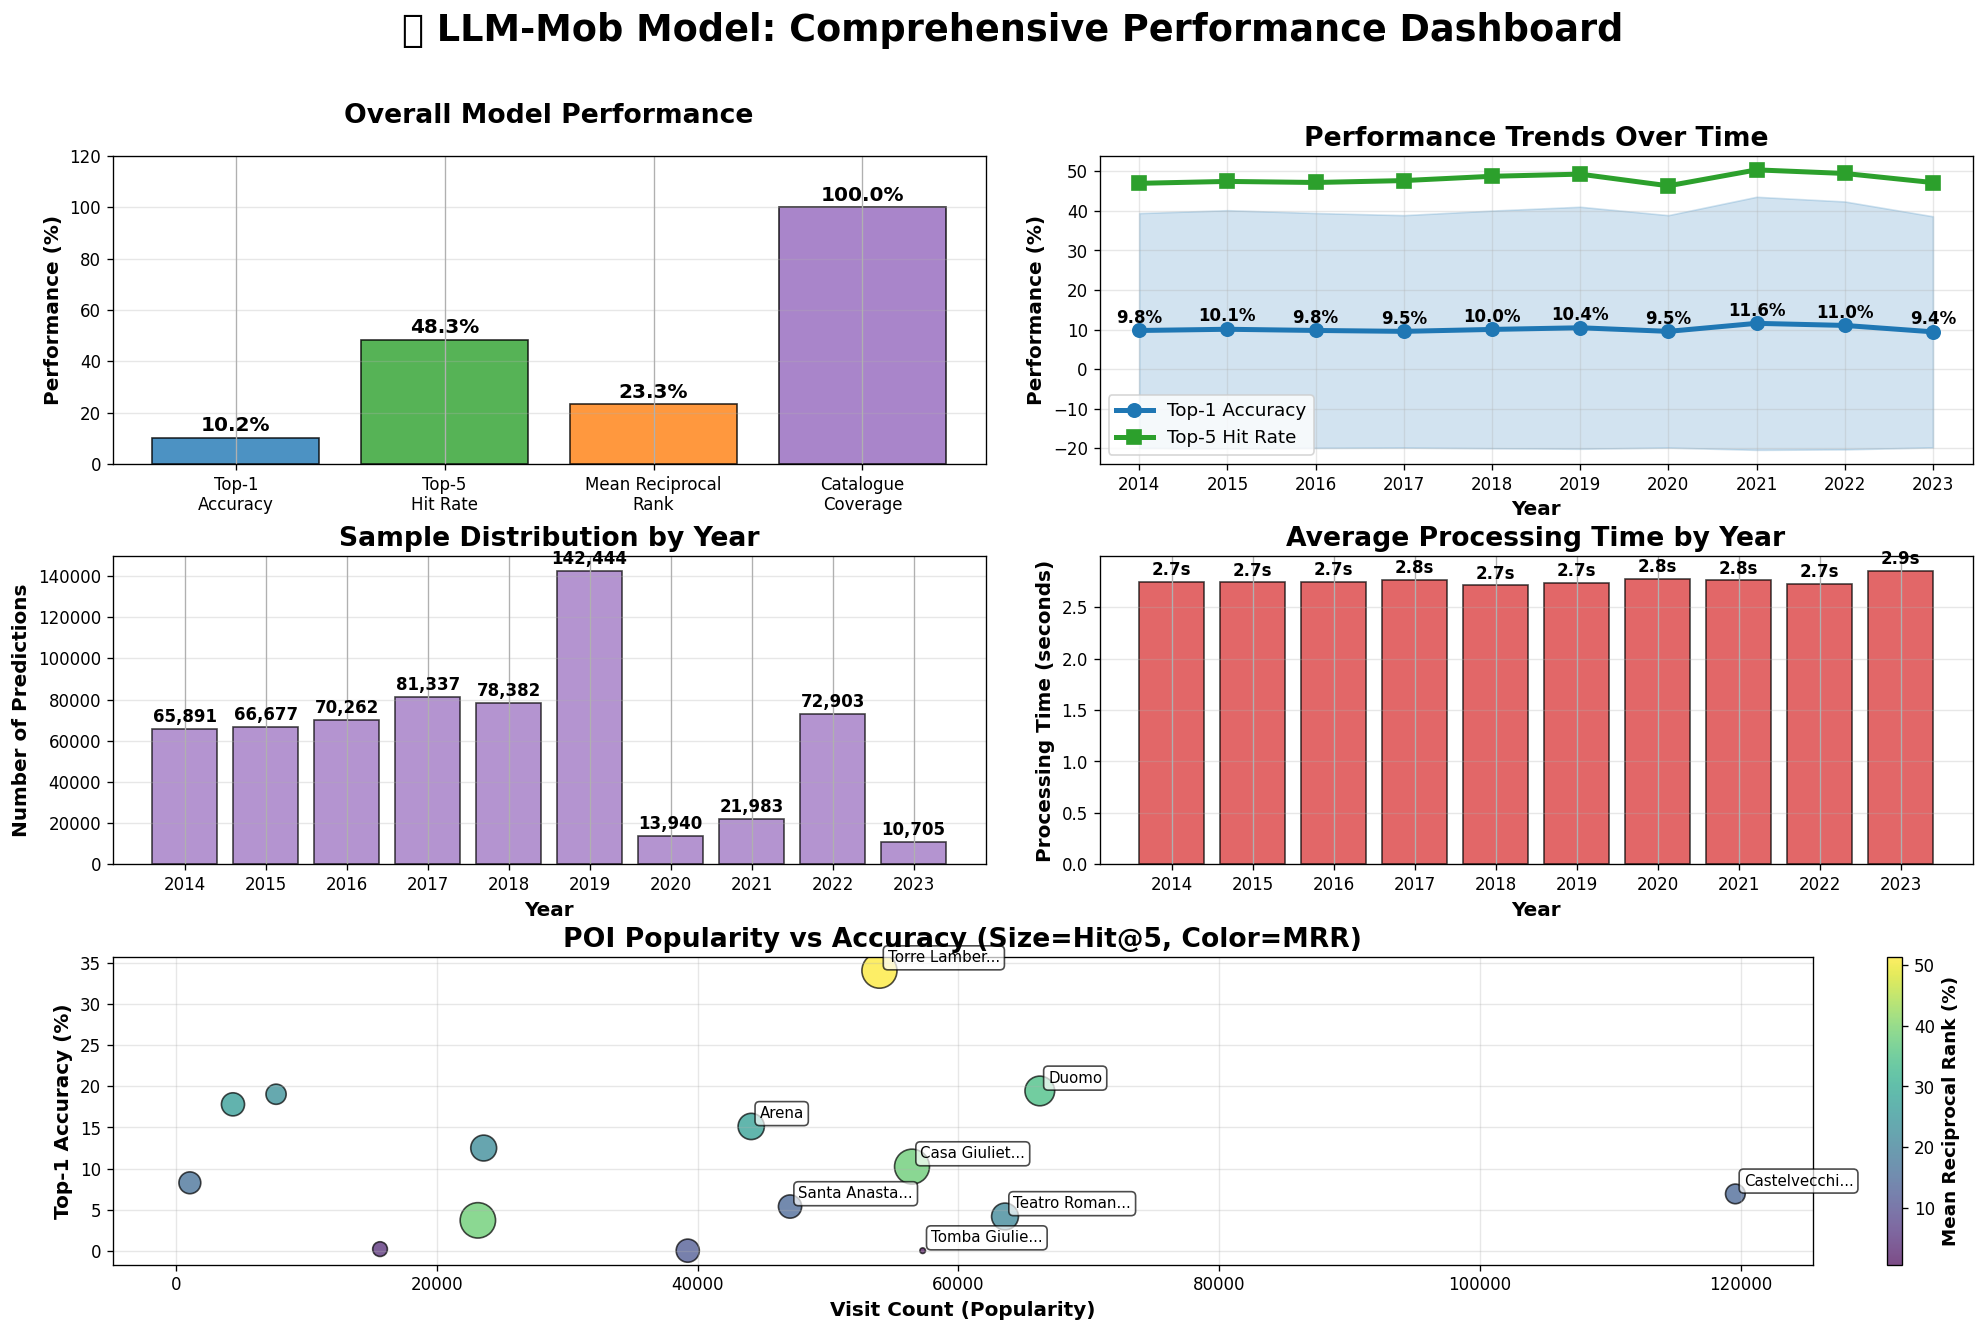


🔍 Correlation Analysis:
   • Popularity vs Accuracy: -0.045
   • Popularity vs Hit@5: 0.075
   • Accuracy vs MRR: 0.753


In [7]:
# Comprehensive Performance Dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1, 1], hspace=0.3, wspace=0.3)

# Color palette
colors = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e', 
    'success': '#2ca02c',
    'warning': '#d62728',
    'info': '#9467bd'
}

# 1. Overall metrics (top row, left)
ax_overall = fig.add_subplot(gs[0, :2])
metrics_values = [
    metrics_global["Top-1 Accuracy"] * 100,
    metrics_global["Top-5 Hit Rate"] * 100,
    metrics_global["Mean Reciprocal Rank"] * 100,
    min(metrics_global["Catalogue Coverage"] * 100, 100)  # Cap at 100% for visualization
]
metrics_names = ["Top-1\nAccuracy", "Top-5\nHit Rate", "Mean Reciprocal\nRank", "Catalogue\nCoverage"]
metric_colors = [colors['primary'], colors['success'], colors['secondary'], colors['info']]

bars = ax_overall.bar(metrics_names, metrics_values, color=metric_colors, alpha=0.8, edgecolor='black', linewidth=1)
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax_overall.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

ax_overall.set_title('Overall Model Performance', fontsize=16, fontweight='bold', pad=20)
ax_overall.set_ylabel('Performance (%)', fontsize=12, fontweight='bold')
ax_overall.grid(True, alpha=0.3, axis='y')
ax_overall.set_ylim(0, max(metrics_values) * 1.2)

# 2. Performance trend over time (top row, right)
ax_trend = fig.add_subplot(gs[0, 2:])
years = by_year['year'].astype(int)
ax_trend.plot(years, by_year['top1_acc']*100, 'o-', linewidth=3, markersize=8, 
             color=colors['primary'], label='Top-1 Accuracy')
ax_trend.plot(years, by_year['hit5_rate']*100, 's-', linewidth=3, markersize=8,
             color=colors['success'], label='Top-5 Hit Rate')
ax_trend.fill_between(years, 
                     (by_year['top1_acc'] - by_year['top1_std'])*100,
                     (by_year['top1_acc'] + by_year['top1_std'])*100,
                     alpha=0.2, color=colors['primary'])

# Add value annotations
for i, year in enumerate(years):
    ax_trend.annotate(f"{by_year.iloc[i]['top1_acc']*100:.1f}%", 
                     (year, by_year.iloc[i]['top1_acc']*100 + 2), 
                     ha='center', fontsize=10, fontweight='bold')

ax_trend.set_title('Performance Trends Over Time', fontsize=16, fontweight='bold')
ax_trend.set_ylabel('Performance (%)', fontsize=12, fontweight='bold')
ax_trend.set_xlabel('Year', fontsize=12, fontweight='bold')
ax_trend.legend(fontsize=11)
ax_trend.grid(True, alpha=0.3)
ax_trend.set_xticks(years)

# 3. Sample distribution (middle row, left)
ax_samples = fig.add_subplot(gs[1, :2])
bars_samples = ax_samples.bar(years.astype(str), by_year['sample_size'], 
                             color=colors['info'], alpha=0.7, edgecolor='black')
for bar, value in zip(bars_samples, by_year['sample_size']):
    ax_samples.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(by_year['sample_size'])*0.01,
                   f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax_samples.set_title('Sample Distribution by Year', fontsize=16, fontweight='bold')
ax_samples.set_ylabel('Number of Predictions', fontsize=12, fontweight='bold')
ax_samples.set_xlabel('Year', fontsize=12, fontweight='bold')
ax_samples.grid(True, alpha=0.3, axis='y')

# 4. Processing time analysis (middle row, right)
ax_time = fig.add_subplot(gs[1, 2:])
bars_time = ax_time.bar(years.astype(str), by_year['avg_time'],
                       color=colors['warning'], alpha=0.7, edgecolor='black')
for bar, value in zip(bars_time, by_year['avg_time']):
    ax_time.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(by_year['avg_time'])*0.01,
                f'{value:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax_time.set_title('Average Processing Time by Year', fontsize=16, fontweight='bold')
ax_time.set_ylabel('Processing Time (seconds)', fontsize=12, fontweight='bold')
ax_time.set_xlabel('Year', fontsize=12, fontweight='bold')
ax_time.grid(True, alpha=0.3, axis='y')

# 5. POI popularity vs accuracy (bottom row)
poi_stats = df_all.groupby('ground_truth_norm').agg({
    'hit@1': ['count', 'mean'],
    'hit@5': 'mean',
    'rr': 'mean'
}).round(4)
poi_stats.columns = ['visit_count', 'accuracy', 'hit5_rate', 'mrr']
poi_stats = poi_stats.sort_values('visit_count', ascending=False).head(15)

ax_poi = fig.add_subplot(gs[2, :])
scatter = ax_poi.scatter(poi_stats['visit_count'], poi_stats['accuracy']*100, 
                        s=poi_stats['hit5_rate']*500, # Size based on hit5 rate
                        c=poi_stats['mrr']*100, cmap='viridis', 
                        alpha=0.7, edgecolor='black')

# Add POI labels for top points
for poi, row in poi_stats.head(8).iterrows():
    ax_poi.annotate(poi[:12] + ('...' if len(poi) > 12 else ''), 
                   (row['visit_count'], row['accuracy']*100),
                   xytext=(5, 5), textcoords='offset points', fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax_poi.set_xlabel('Visit Count (Popularity)', fontsize=12, fontweight='bold')
ax_poi.set_ylabel('Top-1 Accuracy (%)', fontsize=12, fontweight='bold')
ax_poi.set_title('POI Popularity vs Accuracy (Size=Hit@5, Color=MRR)', fontsize=16, fontweight='bold')
ax_poi.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax_poi, fraction=0.046, pad=0.04)
cbar.set_label('Mean Reciprocal Rank (%)', fontsize=11, fontweight='bold')

plt.suptitle('🎯 LLM-Mob Model: Comprehensive Performance Dashboard', 
             fontsize=22, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print correlation analysis
print(f"\n🔍 Correlation Analysis:")
print(f"   • Popularity vs Accuracy: {poi_stats['visit_count'].corr(poi_stats['accuracy']):.3f}")
print(f"   • Popularity vs Hit@5: {poi_stats['visit_count'].corr(poi_stats['hit5_rate']):.3f}")
print(f"   • Accuracy vs MRR: {poi_stats['accuracy'].corr(poi_stats['mrr']):.3f}")

## 4. 🔍 Advanced Error Analysis

Deep dive into model failures and error patterns.

In [8]:
# Comprehensive error analysis
print("🔍 ADVANCED ERROR ANALYSIS")
print("=" * 50)

# Separate errors from correct predictions
err_rows = df_all[~df_all["hit@1"]].copy()
correct_rows = df_all[df_all["hit@1"]].copy()

if err_rows.empty:
    print("🎉 No Top-1 errors to analyze - perfect model performance!")
else:
    # Add helper columns
    err_rows['first_pred'] = err_rows["prediction_norm"].str[0]
    correct_rows['first_pred'] = correct_rows["prediction_norm"].str[0]
    
    print(f"📊 Dataset Overview:")
    print(f"   • Total predictions: {len(df_all):,}")
    print(f"   • Correct predictions: {len(correct_rows):,} ({len(correct_rows)/len(df_all):.1%})")
    print(f"   • Prediction errors: {len(err_rows):,} ({len(err_rows)/len(df_all):.1%})")
    
    # 1. Error distribution by POI
    print(f"\n1️⃣ ERROR DISTRIBUTION BY POI")
    print("-" * 40)
    
    error_by_poi = (
        err_rows['ground_truth_norm']
        .value_counts()
        .head(10)
        .to_frame(name='error_count')
    )
    
    # Calculate error rates
    total_by_poi = df_all['ground_truth_norm'].value_counts()
    error_by_poi['total_count'] = error_by_poi.index.map(total_by_poi)
    error_by_poi['error_rate'] = error_by_poi['error_count'] / error_by_poi['total_count']
    error_by_poi['success_rate'] = 1 - error_by_poi['error_rate']
    
    print("Most problematic POI (by error count):")
    for poi, row in error_by_poi.iterrows():
        print(f"   {poi[:25]:>25s}: {row['error_count']:>4d} errors ({row['error_rate']:>5.1%} rate, {row['total_count']:>4d} total)")
    
    # 2. Most frequent wrong predictions
    print(f"\n2️⃣ MOST FREQUENT WRONG PREDICTIONS")
    print("-" * 40)
    
    wrong_pred_freq = err_rows['first_pred'].value_counts().head(10)
    total_wrong = len(err_rows)
    
    print("Most frequently predicted (incorrectly):")
    for poi, freq in wrong_pred_freq.items():
        percentage = freq / total_wrong * 100
        print(f"   {poi[:25]:>25s}: {freq:>4d} times ({percentage:>5.1f}% of errors)")
    
    # 3. Worst POI pairs (True → Predicted)
    print(f"\n3️⃣ WORST-PERFORMING POI PAIRS")
    print("-" * 40)
    
    pairs = (
        err_rows.groupby(["ground_truth_norm", "first_pred"])
               .size()
               .reset_index(name="errors")
               .sort_values("errors", ascending=False)
               .head(10)
    )
    
    print("Most problematic prediction pairs (True → Predicted):")
    for _, row in pairs.iterrows():
        percentage = row['errors'] / total_wrong * 100
        print(f"   {row['ground_truth_norm'][:15]:>15s} → {row['first_pred'][:15]:<15s}: {row['errors']:>3d} ({percentage:>4.1f}%)")
    
    # 4. Temporal error patterns
    print(f"\n4️⃣ ERROR PATTERNS BY YEAR")
    print("-" * 40)
    
    error_by_year = (
        df_all.groupby('year')
              .agg({'hit@1': ['count', 'mean'], 'processing_time': 'mean'})
              .round(3)
    )
    error_by_year.columns = ['total_preds', 'accuracy', 'avg_time']
    error_by_year['error_rate'] = 1 - error_by_year['accuracy']
    
    print("Error rates by year:")
    for year, row in error_by_year.iterrows():
        if not pd.isna(year):
            print(f"   {int(year)}: {row['error_rate']:>6.1%} error rate ({row['total_preds']:>5,} predictions, {row['avg_time']:>5.1f}s avg)")
    
    # 5. Performance variability analysis
    print(f"\n5️⃣ PERFORMANCE VARIABILITY")
    print("-" * 40)
    
    # Calculate coefficient of variation for accuracy across years
    acc_cv = error_by_year['accuracy'].std() / error_by_year['accuracy'].mean()
    time_cv = error_by_year['avg_time'].std() / error_by_year['avg_time'].mean()
    
    print(f"Model consistency metrics:")
    print(f"   • Accuracy coefficient of variation: {acc_cv:.3f} ({'High' if acc_cv > 0.2 else 'Medium' if acc_cv > 0.1 else 'Low'} variability)")
    print(f"   • Processing time CV: {time_cv:.3f} ({'High' if time_cv > 0.5 else 'Medium' if time_cv > 0.2 else 'Low'} variability)")
    print(f"   • Best performing year: {error_by_year['accuracy'].idxmax():.0f} ({error_by_year['accuracy'].max():.1%} accuracy)")
    print(f"   • Worst performing year: {error_by_year['accuracy'].idxmin():.0f} ({error_by_year['accuracy'].min():.1%} accuracy)")

print(f"\n" + "=" * 50)
print("ERROR ANALYSIS COMPLETE")
print("=" * 50)

🔍 ADVANCED ERROR ANALYSIS
📊 Dataset Overview:
   • Total predictions: 624,524
   • Correct predictions: 63,450 (10.2%)
   • Prediction errors: 561,074 (89.8%)

1️⃣ ERROR DISTRIBUTION BY POI
----------------------------------------
Most problematic POI (by error count):


ValueError: Unknown format code 'd' for object of type 'float'

In [ ]:
# Visualization of error patterns
if not err_rows.empty:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Top error pairs (horizontal bar chart)
    pairs_viz = pairs.head(8)
    colors_grad = plt.cm.Reds(np.linspace(0.4, 0.9, len(pairs_viz)))
    
    bars1 = ax1.barh(range(len(pairs_viz)), pairs_viz['errors'], 
                     color=colors_grad, edgecolor='black', alpha=0.8)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars1, pairs_viz['errors'])):
        ax1.text(bar.get_width() + max(pairs_viz['errors'])*0.01, bar.get_y() + bar.get_height()/2,
                f'{value}', ha='left', va='center', fontweight='bold')
    
    ax1.set_yticks(range(len(pairs_viz)))
    ax1.set_yticklabels([f"{row['ground_truth_norm'][:10]}\n→{row['first_pred'][:10]}" 
                        for _, row in pairs_viz.iterrows()], fontsize=9)
    ax1.set_xlabel('Error Count', fontweight='bold')
    ax1.set_title('Top Error Pairs (True → Predicted)', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.invert_yaxis()
    
    # 2. Error rate by POI popularity
    error_by_poi_viz = error_by_poi.head(10)
    x_pos = range(len(error_by_poi_viz))
    
    bars2 = ax2.bar(x_pos, error_by_poi_viz['error_rate']*100, 
                    color=plt.cm.RdYlBu_r(error_by_poi_viz['error_rate']), 
                    edgecolor='black', alpha=0.8)
    
    # Add value labels
    for bar, value in zip(bars2, error_by_poi_viz['error_rate']*100):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([poi[:10] + ('...' if len(poi) > 10 else '') 
                        for poi in error_by_poi_viz.index], rotation=45, ha='right')
    ax2.set_ylabel('Error Rate (%)', fontweight='bold')
    ax2.set_title('Error Rate by POI (Top 10 by Error Count)', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Accuracy vs processing time scatter
    scatter_data = by_year.copy()
    scatter = ax3.scatter(scatter_data['avg_time'], scatter_data['top1_acc']*100,
                         s=scatter_data['sample_size']/50, # Size based on sample size
                         c=scatter_data['year'], cmap='viridis',
                         alpha=0.7, edgecolor='black')
    
    # Add year labels
    for _, row in scatter_data.iterrows():
        ax3.annotate(f"{int(row['year'])}", 
                    (row['avg_time'], row['top1_acc']*100),
                    xytext=(3, 3), textcoords='offset points', fontsize=10, fontweight='bold')
    
    ax3.set_xlabel('Average Processing Time (seconds)', fontweight='bold')
    ax3.set_ylabel('Top-1 Accuracy (%)', fontweight='bold')
    ax3.set_title('Accuracy vs Processing Time by Year\n(Bubble size = Sample size)', fontweight='bold', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # 4. Wrong predictions distribution
    wrong_viz = wrong_pred_freq.head(8)
    bars4 = ax4.bar(range(len(wrong_viz)), wrong_viz.values,
                    color=plt.cm.OrRd(np.linspace(0.4, 0.9, len(wrong_viz))),
                    edgecolor='black', alpha=0.8)
    
    # Add value labels
    for bar, value in zip(bars4, wrong_viz.values):
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(wrong_viz.values)*0.01,
                f'{value:,}', ha='center', va='bottom', fontweight='bold')
    
    ax4.set_xticks(range(len(wrong_viz)))
    ax4.set_xticklabels([poi[:10] + ('...' if len(poi) > 10 else '') 
                        for poi in wrong_viz.index], rotation=45, ha='right')
    ax4.set_ylabel('Frequency', fontweight='bold')
    ax4.set_title('Most Frequently Wrong Predictions', fontweight='bold', fontsize=14)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('🔍 Error Analysis Dashboard', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

### 3.4 Individual Metric Analysis

Detailed individual charts for each performance metric with enhanced styling.

In [ ]:
# Confusion Matrix for Top POI
print("📊 Creating confusion matrix for top POI...")

# Configuration for confusion matrix
TOP_K_POI = 15  # Number of top POI to include in confusion matrix
YEAR_FILTER = None  # Set to specific year or None for all years

# Filter data
subset = df_all.copy()
if YEAR_FILTER is not None:
    subset = subset.query("year == @YEAR_FILTER")
    print(f"   Filtering for year: {YEAR_FILTER}")

# Get top POI by frequency in ground truth
top_poi = (
    subset["ground_truth_norm"]
           .value_counts()
           .head(TOP_K_POI)
           .index.tolist()
)

print(f"   Analyzing top {TOP_K_POI} POI by frequency")
print(f"   Dataset size: {len(subset):,} predictions")

# Filter for rows where both true and predicted POI are in the top list
mask = (subset["ground_truth_norm"].isin(top_poi) & 
        subset["prediction_norm"].str[0].isin(top_poi))

filtered_data = subset.loc[mask]
print(f"   Filtered to {len(filtered_data):,} predictions involving top POI")

if len(filtered_data) > 0:
    # Create confusion matrix
    cm_df = pd.crosstab(
        filtered_data["ground_truth_norm"],
        filtered_data["prediction_norm"].str[0],
        rownames=["True POI"],
        colnames=["Predicted POI"],
        dropna=False
    )
    
    # Normalize by rows to get error rates
    cm_norm = cm_df.div(cm_df.sum(axis=1), axis=0)
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Use a color map that highlights errors (low diagonal values)
    im = ax.imshow(cm_norm.values, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)
    
    # Set ticks and labels
    ax.set_xticks(range(len(cm_norm.columns)))
    ax.set_xticklabels([col[:15] + ('...' if len(col) > 15 else '') for col in cm_norm.columns], 
                      rotation=45, ha='right', fontsize=9)
    ax.set_yticks(range(len(cm_norm.index)))
    ax.set_yticklabels([idx[:15] + ('...' if len(idx) > 15 else '') for idx in cm_norm.index], 
                      fontsize=9)
    
    # Add text annotations
    for i in range(len(cm_norm.index)):
        for j in range(len(cm_norm.columns)):
            value = cm_norm.iloc[i, j]
            count = cm_df.iloc[i, j]
            if not np.isnan(value):
                # Use white text for dark cells, black for light cells
                text_color = 'white' if value < 0.5 else 'black'
                ax.text(j, i, f'{value:.2f}\n({count})', ha='center', va='center',
                       color=text_color, fontsize=8, fontweight='bold')
    
    ax.set_xlabel('Predicted POI', fontsize=12, fontweight='bold')
    ax.set_ylabel('True POI', fontsize=12, fontweight='bold')
    title = f'Confusion Matrix - Top {TOP_K_POI} POI'
    if YEAR_FILTER:
        title += f' (Year {YEAR_FILTER})'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Prediction Rate', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📈 Confusion Matrix Summary:")
    diagonal_accuracy = np.diag(cm_norm).mean()
    print(f"   • Average diagonal accuracy: {diagonal_accuracy:.2%}")
    
    # Find most accurate predictions (highest diagonal values)
    diagonal_values = pd.Series(np.diag(cm_norm), index=cm_norm.index).sort_values(ascending=False)
    print(f"   • Most accurate predictions:")
    for poi, acc in diagonal_values.head(5).items():
        count = cm_df.loc[poi, poi]
        total = cm_df.loc[poi].sum()
        print(f"     - {poi[:25]:>25s}: {acc:.2%} ({count:,}/{total:,})")
    
    print(f"   • Least accurate predictions:")
    for poi, acc in diagonal_values.tail(5).items():
        count = cm_df.loc[poi, poi]
        total = cm_df.loc[poi].sum()
        print(f"     - {poi[:25]:>25s}: {acc:.2%} ({count:,}/{total:,})")

else:
    print("❌ No data available for confusion matrix creation")

In [ ]:
# Worst Performing POI Pairs
print("🔍 Analyzing worst-performing POI pairs...")

# Filter error rows and create pairs analysis
if 'hit@1' in df_all.columns:
    err_rows_individual = df_all[~df_all["hit@1"]].copy()
    if not err_rows_individual.empty:
        # Add first prediction column
        err_rows_individual['first_pred'] = err_rows_individual["prediction_norm"].str[0]
        
        # Count error pairs
        pairs_individual = (
            err_rows_individual.groupby(["ground_truth_norm", "first_pred"])
                  .size()
                  .reset_index(name="errors")
                  .sort_values("errors", ascending=False)
                  .head(15)
        )
        
        # Create horizontal bar chart
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Create labels for pairs
        pair_labels = [f"{row['ground_truth_norm'][:12]} → {row['first_pred'][:12]}" 
                      for _, row in pairs_individual.iterrows()]
        
        colors_gradient = plt.cm.Reds(np.linspace(0.4, 0.9, len(pairs_individual)))
        bars = ax.barh(range(len(pairs_individual)), pairs_individual["errors"], 
                       color=colors_gradient, edgecolor='black', alpha=0.8)
        
        # Add value labels
        for i, (bar, value) in enumerate(zip(bars, pairs_individual["errors"])):
            ax.text(bar.get_width() + max(pairs_individual["errors"])*0.01, 
                   bar.get_y() + bar.get_height()/2,
                   f'{value:,}', ha='left', va='center', fontweight='bold', fontsize=10)
        
        ax.set_yticks(range(len(pairs_individual)))
        ax.set_yticklabels(pair_labels, fontsize=9)
        ax.set_xlabel('Number of Errors', fontsize=12, fontweight='bold')
        ax.set_title('Worst-Performing POI Pairs (True → Predicted) - Top 15', 
                    fontsize=14, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3, axis='x')
        ax.invert_yaxis()
        
        plt.tight_layout()
        plt.show()
        
        # Display pairs data
        print("Top 10 worst-performing POI pairs:")
        for i, (_, row) in enumerate(pairs_individual.head(10).iterrows(), 1):
            percentage = row['errors'] / len(err_rows_individual) * 100
            print(f"  {i:2d}. {row['ground_truth_norm'][:20]:>20s} → {row['first_pred'][:20]:<20s}: {row['errors']:>4,} errors ({percentage:4.1f}%)")
    else:
        print("✅ No Top-1 errors found to analyze!")
else:
    print("⚠️  hit@1 column not found - skipping pairs analysis")

In [ ]:
# Mean Reciprocal Rank (MRR) by Year
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(by_year['year'].astype(str), by_year['mrr']*100,
              color='#ff7f0e', alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels on bars
for bar, value in zip(bars, by_year['mrr']*100):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
           f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('MRR (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_title('Mean Reciprocal Rank (%) by Year', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(by_year['mrr']*100) * 1.15)

# Add trend line
x_numeric = range(len(by_year))
z = np.polyfit(x_numeric, by_year['mrr']*100, 1)
p = np.poly1d(z)
ax.plot(by_year['year'].astype(str), p(x_numeric), "r--", alpha=0.8, linewidth=2, label=f'Trend (slope: {z[0]:.1f}%/year)')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Top-5 Hit Rate by Year
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(by_year['year'].astype(str), by_year['hit5_rate']*100,
              color='#2ca02c', alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels on bars
for bar, value in zip(bars, by_year['hit5_rate']*100):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
           f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('Top‑5 Hit Rate (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_title('Top‑5 Hit Rate (%) by Year', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(by_year['hit5_rate']*100) * 1.15)

# Add trend line
x_numeric = range(len(by_year))
z = np.polyfit(x_numeric, by_year['hit5_rate']*100, 1)
p = np.poly1d(z)
ax.plot(by_year['year'].astype(str), p(x_numeric), "r--", alpha=0.8, linewidth=2, label=f'Trend (slope: {z[0]:.1f}%/year)')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Top-1 Accuracy by Year
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(by_year['year'].astype(str), by_year['top1_acc']*100, 
              color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels on bars
for bar, value in zip(bars, by_year['top1_acc']*100):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
           f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('Top‑1 Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_title('Top‑1 Accuracy (%) by Year', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(by_year['top1_acc']*100) * 1.15)

# Add trend line
x_numeric = range(len(by_year))
z = np.polyfit(x_numeric, by_year['top1_acc']*100, 1)
p = np.poly1d(z)
ax.plot(by_year['year'].astype(str), p(x_numeric), "r--", alpha=0.8, linewidth=2, label=f'Trend (slope: {z[0]:.1f}%/year)')
ax.legend()

plt.tight_layout()
plt.show()

## 5. 📋 Executive Summary

Key findings and actionable insights from the analysis.

In [ ]:
# Generate executive summary
print("📋 EXECUTIVE SUMMARY")
print("=" * 60)

print(f"\n🎯 OVERALL PERFORMANCE:")
print(f"   • Model achieved {metrics_global['Top-1 Accuracy']:.1%} top-1 accuracy")
print(f"   • {metrics_global['Top-5 Hit Rate']:.1%} of correct answers appear in top-5 predictions")
print(f"   • Mean Reciprocal Rank: {metrics_global['Mean Reciprocal Rank']:.1%}")
print(f"   • Catalogue coverage: {metrics_global['Catalogue Coverage']:.1%} of available POI")

if len(by_year) > 1:
    print(f"\n📈 TEMPORAL TRENDS:")
    best_year = by_year.loc[by_year['top1_acc'].idxmax()]
    worst_year = by_year.loc[by_year['top1_acc'].idxmin()]
    
    print(f"   • Best performing year: {int(best_year['year'])} ({best_year['top1_acc']:.1%} accuracy)")
    print(f"   • Worst performing year: {int(worst_year['year'])} ({worst_year['top1_acc']:.1%} accuracy)")
    print(f"   • Performance range: {(best_year['top1_acc'] - worst_year['top1_acc']):.1%} difference")
    print(f"   • Consistency: {'High' if by_year['top1_acc'].std() < 0.05 else 'Medium' if by_year['top1_acc'].std() < 0.10 else 'Low'}")

if not err_rows.empty:
    print(f"\n🔍 ERROR ANALYSIS:")
    most_problematic = error_by_poi.iloc[0]
    most_wrong_pred = wrong_pred_freq.iloc[0]
    worst_pair = pairs.iloc[0]
    
    print(f"   • Most problematic POI: {most_problematic.name} ({most_problematic['error_rate']:.1%} error rate)")
    print(f"   • Most frequent wrong prediction: {most_wrong_pred.name} ({most_wrong_pred} times)")
    print(f"   • Worst prediction pair: {worst_pair['ground_truth_norm']} → {worst_pair['first_pred']} ({worst_pair['errors']} errors)")

print(f"\n⚡ PERFORMANCE INSIGHTS:")
avg_time = df_all['processing_time'].mean()
print(f"   • Average processing time: {avg_time:.2f} seconds per prediction")
print(f"   • Success rate: {df_all['status'].eq('success').mean():.1%}")
print(f"   • Data quality: {((total_rows_processed)/(total_rows_processed+skipped_rows+parse_errors))*100:.1f}% of raw data successfully processed")

# Recommendations
print(f"\n💡 RECOMMENDATIONS:")

if metrics_global['Top-1 Accuracy'] < 0.3:
    print(f"   • ❗ Consider model retraining - accuracy below 30%")
elif metrics_global['Top-1 Accuracy'] < 0.5:
    print(f"   • ⚠️  Model performance could be improved - consider fine-tuning")
else:
    print(f"   • ✅ Model performance is acceptable")

if len(by_year) > 1 and by_year['top1_acc'].std() > 0.1:
    print(f"   • 📊 High year-to-year variability detected - investigate data quality differences")

if not err_rows.empty and error_by_poi.iloc[0]['error_rate'] > 0.8:
    print(f"   • 🎯 Focus on improving predictions for '{error_by_poi.index[0]}' (highest error rate)")

if avg_time > 30:
    print(f"   • ⚡ Consider optimizing model inference - average time exceeds 30s")
elif avg_time < 1:
    print(f"   • ⚡ Excellent inference speed - under 1s per prediction")

print(f"\n📊 DATASET STATISTICS:")
print(f"   • Total predictions analyzed: {len(df_all):,}")
print(f"   • Time period: {int(df_all['year'].min())}-{int(df_all['year'].max())}")
print(f"   • Unique POI in ground truth: {df_all['ground_truth_norm'].nunique()}")
print(f"   • Data processing success rate: {((total_rows_processed)/(total_rows_processed+skipped_rows+parse_errors))*100:.1f}%")

print(f"\n" + "=" * 60)
print(f"Analysis completed successfully! 🎉")
print(f"Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)